# Kaggle Dogs vs. Cats Redux: Kernels Edition
## My Convolutional Neural Networks Implementation
Task: Distinguish images of dogs from cats 

In [2]:
%matplotlib inline
import math, os, json, sys, re
import numpy as np
from matplotlib import pyplot as plt
import bcolz
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.np_utils import to_categorical

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
path = 'data/dogs-cats-redux/sample/'
#path = 'data/dogs-cats-redux/'
model_path = 'data/dogs-cats-redux/models/'
batch_size=64
print os.path.exists(model_path)
print os.path.exists(path)

True
True


# Use of Pretrained VGG Model

Use a model that has been fully created and which can recognise a wide variety (1,000 categories) of images. 'VGG' won the 2014 Imagenet competition and is a simple model to create and understand. The Python class *Vgg16* offers the functioality to use the VGG 16 model in a straightforward manner.

Import the mappings from VGG ids to imagenet category ids and descriptions, for display purposes later.

In [6]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
classes[:5]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']

In [4]:
# Import vgg16 class and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


## Model creation

Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by defining the basic pieces of the VGG architecture.

VGG has just one type of convolutional block, and one type of fully connected ('dense') block. Here's the convolutional block definition:

In [7]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

...and here's the fully-connected definition.

In [8]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermore, their software that expected the channels to be in B,G,R order, whereas Python by default uses R,G,B. We need to preprocess our data to make these two changes, so that it is compatible with the VGG model:

In [9]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

Now we're ready to define the VGG model architecture - look at how simple it is, now that we have the basic blocks defined!

In [10]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

- Convolution layers are for finding patterns in images
- Dense (fully connected) layers are for combining patterns across an image

Now that we've defined the architecture, we can create the model like any python object:

In [11]:
model = VGG_16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:621: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defined based on the nature of the problem.
Downloading pre-trained weights is much preferred to training the model ourselves, since otherwise we would have to download the entire Imagenet archive, and train the model for many days! It's very helpful when researchers release their weights, as they did here.

In [12]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Getting imagenet predictions

The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [13]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of labels to create, whether to randomly shuffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [26]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Keras reads groups of images and labels in batches, using a fixed directory structure, where images from each category for training must be placed in a separate folder.

In [15]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size)

Found 199 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


Each iteration returns both the images themselves, as well as the labels.

In [16]:
imgs,labels = next(batches)

The labels for each image are an array, containing a 1 in the first position if it's a cat, and in the second position if it's a dog

In [17]:
print(labels)

[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


Function to plot imges inline

In [19]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

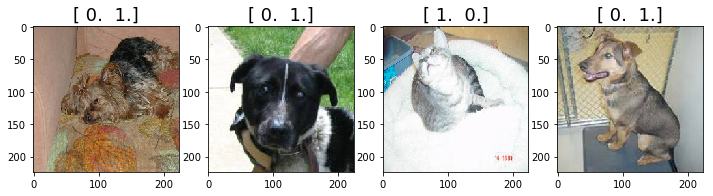

In [20]:
plots(imgs, titles=labels)

The VGG model returns 1,000 probabilities for each image, representing the probability that the model assigns to each possible imagenet category for each image. By finding the index with the largest probability (with np.argmax()) we can find the predicted label.

In [21]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [22]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  3.78772143e-08   8.98097099e-08   1.21236159e-08   1.92916616e-08
   1.52337464e-07]

Predictions prob/class: 
  0.5605/silky_terrier
  0.3102/American_Staffordshire_terrier
  0.1148/lynx
  0.1275/Border_terrier


## Finetune a Dogs vs Cats Model

Change model so that it outputs "cat" vs "dog" instead of one of 1,000 very specific categories. Use a process called "finetuning". We start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very similar, or the same, between the existing model, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call fit() after calling finetune().

Path to all Kaggle training data

In [24]:
path = "data/dogs-cats-redux/"
print os.path.exists(path)

True


We create our batches just like before, and making the validation set available as well. A 'batch' (or mini-batch as it is commonly known) is simply a subset of the training data - we use a subset at a time when training or predicting, in order to speed up training, and to avoid running out of memory.

In [27]:
batch_size=64
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Retrain last layer's linear model
Since the original VGG16 network's last layer is Dense (i.e. a linear model) it seems a little odd that we are adding an additional linear model on top of it. This is especially true since the last layer had a softmax activation, which is an odd choice for an intermediate layer--and by adding an extra layer on top of it, we have made it an intermediate layer. What if we just removed the original final layer and replaced it with one that we train for the purpose of distinguishing cats and dogs? It turns out that this is a good idea - as we'll see!

We start by removing the last layer, and telling Keras that we want to fix the weights in all the other layers (since we aren't looking to learn new parameters for those other layers).

In [30]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

We will finetune the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [31]:
model.pop()
for layer in model.layers: layer.trainable=False

**Careful!** Now that we've modified the definition of *model*, be careful not to rerun any code in the previous sections, without first recreating the model from scratch! (Yes, I made that mistake myself, which is why I'm warning you about it now...)

Now we're ready to add our new final layer...

In [32]:
model.add(Dense(2, activation='softmax'))

...and compile our updated model, and set up our batches to use the preprocessed images (note that now we will also *shuffle* the training batches, to add more randomness when using multiple epochs):

In [33]:
opt = RMSprop(lr=0.1)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

We'll define a simple function for fitting models, just to save a little typing...

In [34]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    model.fit_generator(batches, samples_per_epoch=batches.N, nb_epoch=nb_epoch, 
                        validation_data=val_batches, nb_val_samples=val_batches.N)

A simple function that joins the arrays from all the batches - let's use this to grab the training and validation data:

In [39]:
def get_data(path, batches, target_size=(224,224)):
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])

In [ ]:
val_data = get_data(path+'valid', val_batches)

In [ ]:
val_data.shape

In [ ]:
trn_data = get_data(path+'train', batches)

In [ ]:
trn_data.shape

Loading and resizing the images every time we want to use them isn't necessary - instead we should save the processed arrays. By far the fastest way to save and load numpy arrays is using bcolz. This also compresses the arrays, so we save disk space. Here are the functions we'll use to save and load using bcolz.

In [ ]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [ ]:
save_array(model_path+ 'train_data.bc', trn_data)
save_array(model_path + 'valid_data.bc', val_data)

We can load our training and validation data later without recalculating them:

In [ ]:
trn_data = load_array(model_path+'train_data.bc')
val_data = load_array(model_path+'valid_data.bc')

Setup batches

In [ ]:
gen=image.ImageDataGenerator()
batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

Finally, we fit() the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An epoch is one full pass through the training data.)

In [7]:
fit_model(model, batches, val_batches, nb_epoch=2)

Epoch 1/1
23000/23000 [==============================] - 619s - loss: 0.1156 - acc: 0.9692 - val_loss: 0.0485 - val_acc: 0.9880


In [ ]:
model.save_weights(model_path+'dogs-cats-redux-model.h5')

In [ ]:
model.evaluate(val_data, val_labels)

## Run Extra Epochs

In [8]:
fit_model(model, batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 618s - loss: 0.0951 - acc: 0.9764 - val_loss: 0.0513 - val_acc: 0.9840


Change learning rate from 0.1 to 0.01

In [9]:
model.optimizer.lr = 0.01

In [10]:
fit_model(model, batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 615s - loss: 0.1081 - acc: 0.9773 - val_loss: 0.0603 - val_acc: 0.9835


In [15]:
fit_model(model, batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 619s - loss: 0.1029 - acc: 0.9777 - val_loss: 0.0646 - val_acc: 0.9865


Save whole model to a file

In [17]:
model.save_weights(model_path+'dogs-cats-redux-ext-epochs-weights.h5')

## Running on Test Set and saving Results to File (T.B.D.!!!)

In [16]:
batches, predicts = vgg.test(path+'test/', batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [18]:
# np.savetxt("predicts_1.csv", [x[0] for x in predicts], delimiter=",", fmt="%10.5f")
predicts = [x[1] for x in predicts]
predicts = np.clip(predicts, 0.02, 0.98)
np.savetxt("predicts.csv", predicts, delimiter=",", fmt="%1.5f") # hounddogs

In [21]:
import csv
batches = vgg.get_batches(path+'test/', batch_size=batch_size)
wtr = csv.writer(open ('filenames.csv', 'w'), delimiter=',', lineterminator='\n')
for x in batches.filenames : wtr.writerow ([x])

Found 12500 images belonging to 1 classes.


In [20]:
from IPython.display import FileLink
FileLink("predicts.csv")
FileLink("filenames.csv")

/home/ubuntu/nbs/filenames.csv

## Running Some Tests

In [12]:
batches = vgg.get_batches(path+'test/', batch_size=4)

Found 12500 images belonging to 1 classes.


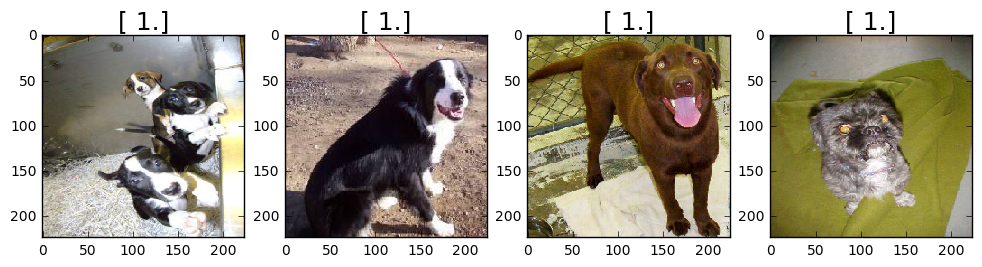

In [13]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [14]:
vgg.predict(imgs, True)

(array([ 1.    ,  1.    ,  1.    ,  0.8736], dtype=float32),
 array([1, 1, 1, 0]),
 [u'goldfish', u'goldfish', u'goldfish', u'tench'])

## Predicting from Test-Directory

In [3]:
path = "data/dogs-cats-redux/"

In [4]:
# from keras.models import load_model
# Import vgg16 class from own library, loading local model and instantiate
import vgg16own; reload(vgg16own)
from vgg16own import Vgg16

vgg = Vgg16()

In [5]:
batches = vgg.get_batches(path+'test', batch_size=4)

Found 12500 images belonging to 1 classes.


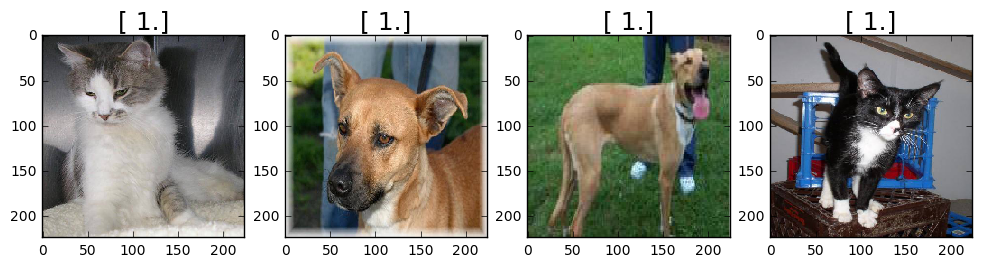

In [6]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [7]:
vgg.predict(imgs, True)

(array([ 1.,  1.,  1.,  1.], dtype=float32),
 array([0, 1, 1, 0]),
 [u'cat', u'dog', u'dog', u'cat'])

## Predicting OneImage

Found 2 images belonging to 1 classes.


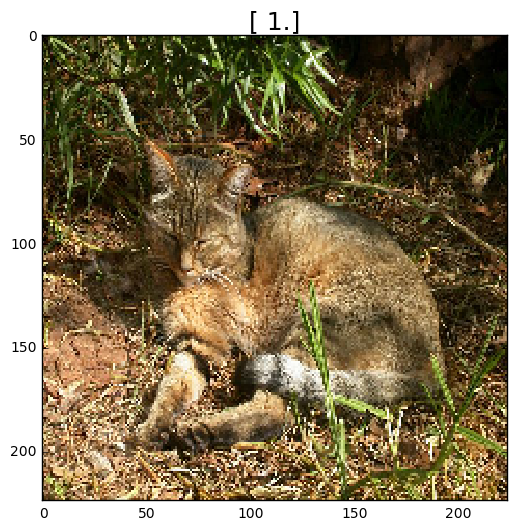

In [8]:
batches = vgg.get_batches(path+'own_test/', batch_size=1)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [16]:
vgg.predict(imgs, True)[0][0]

0.99566507

In [10]:
import cv2
im = cv2.imread('data/dogs-cats-redux/own_test/unknown/AfricanWildCat.jpg')
im = cv2.resize(im, (224, 224))
im = im.astype(np.float32)
im[:,:,0] -= 103.939
im[:,:,1] -= 116.779
im[:,:,2] -= 123.68
im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)

In [11]:
vgg.predict(im, True)[2][0]

u'cat'

In [31]:
print('cat')

cat


In [36]:
"fgg'dfdf".split("'")

['fgg', 'dfdf']